# 多分类支撑向量机练习
*完成此练习并且上交本ipynb（包含输出及代码）.*

在这个练习中，你将会:
    
- 为SVM构建一个完全向量化的**损失函数**
- 实现**解析梯度**的向量化表达式
- 使用数值梯度检查你的代码是否正确
- 使用验证集**调整学习率和正则化项**
- 用**SGD（随机梯度下降）** **优化**损失函数
- **可视化** 最后学习到的权重


In [1]:
# 导入包
import random
import numpy as np
from daseCV.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# 下面一行是notebook的magic命令，作用是让matplotlib在notebook内绘图（而不是新建一个窗口）
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置绘图的默认大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 该magic命令可以重载外部的python模块
# 相关资料可以去看 http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 准备和预处理CIFAR-10的数据

In [2]:
# 导入原始CIFAR-10数据
cifar10_dir = 'daseCV/datasets/cifar-10-batches-py'

# 清空变量，防止多次定义变量（可能造成内存问题）
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 完整性检查，打印出训练和测试数据的大小
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


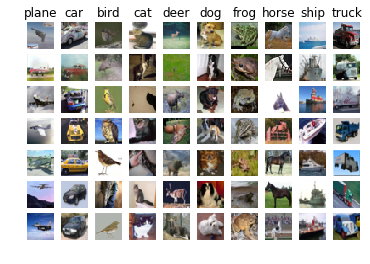

In [3]:
# 可视化部分数据
# 这里我们每个类别展示了7张图片
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# 划分训练集，验证集和测试集，除此之外，
# 我们从训练集中抽取了一小部分作为代码开发的数据，
# 使用小批量的开发数据集能够快速开发代码
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# 从原始训练集中抽取出num_validation个样本作为验证集
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# 从原始训练集中抽取出num_training个样本作为训练集
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# 从训练集中抽取num_dev个样本作为开发数据集
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# 从原始测试集中抽取num_test个样本作为测试集
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# 预处理：把图片数据rehspae成行向量
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# 完整性检查，打印出数据的shape
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


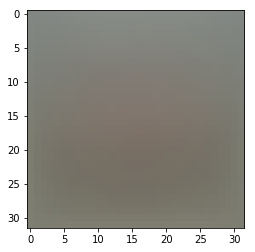

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# 预处理：减去image的平均值（均值规整化）
# 第一步：计算训练集中的图像均值
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# 第二步：所有数据集减去均值
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# 第三步：拼接一个bias维，其中所有值都是1（bias trick），
# SVM可以联合优化数据和bias，即只需要优化一个权值矩阵W
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM分类器

你需要在**daseCV/classifiers/linear_svm.py**里面完成编码

我们已经预先定义了一个函数`compute_loss_naive`，该函数使用循环来计算多分类SVM损失函数

In [7]:
# 调用朴素版的损失计算函数
from daseCV.classifiers.linear_svm import svm_loss_naive
import time

# 生成一个随机的SVM权值矩阵（矩阵值很小）
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.699958


从上面的函数返回的`grad`现在是零。请推导支持向量机损失函数的梯度，并在svm_loss_naive中编码实现。

为了检查是否正确地实现了梯度，你可以用数值方法估计损失函数的梯度，并将数值估计与你计算出来的梯度进行比较。我们已经为你提供了检查的代码:

In [8]:
# 一旦你实现了梯度计算的功能，重新执行下面的代码检查梯度

# 计算损失和W的梯度
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# 数值估计梯度的方法沿着随机几个维度进行计算，并且和解析梯度进行比较，
# 这两个方法算出来的梯度应该在任何维度上完全一致(相对误差足够小)
from daseCV.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# 把正则化项打开后继续再检查一遍梯度
# 你没有忘记正则化项吧？（忘了的罚抄100遍(๑•́ ₃•̀๑) ）
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -21.300662 analytic: -21.300662, relative error: 6.415368e-12
numerical: -9.048680 analytic: -9.048680, relative error: 2.011728e-11
numerical: -12.470335 analytic: -12.470335, relative error: 1.186146e-11
numerical: -26.934139 analytic: -26.934139, relative error: 8.503834e-12
numerical: -13.078869 analytic: -13.078869, relative error: 4.130047e-12
numerical: 0.339980 analytic: 0.339980, relative error: 1.500516e-09
numerical: -4.436112 analytic: -4.436112, relative error: 8.443388e-11
numerical: 4.784867 analytic: 4.784867, relative error: 7.318209e-11
numerical: 4.119658 analytic: 4.119658, relative error: 5.607092e-12
numerical: 49.568959 analytic: 49.568959, relative error: 1.960233e-12
numerical: 11.144963 analytic: 11.144963, relative error: 2.081923e-11
numerical: 4.567297 analytic: 4.567297, relative error: 8.097174e-11
numerical: -2.564955 analytic: -2.564955, relative error: 1.610060e-10
numerical: 25.225329 analytic: 25.225329, relative error: 9.135813e-12
numeri

**问题 1**

有可能会出现某一个维度上的gradcheck没有完全匹配。这个问题是怎么引起的？有必要担心这个问题么？请举一个简单例子，能够导致梯度检查失败。如何改进这个问题？*提示：SVM的损失函数不是严格可微的*

$\color{blue}{ 你的回答：}$ 在损失函数为 0 的时候，不可微，因此会导致梯度检查失败。  


In [9]:
# 接下来实现svm_loss_vectorized函数，目前只计算损失
# 稍后再计算梯度
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from daseCV.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 两种方法算出来的损失应该是相同的，但是向量化实现的方法应该更快
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.699958e+00 computed in 12.101410s
Vectorized loss: 9.699958e+00 computed in 0.105759s
difference: 0.000000


In [10]:
# 完成svm_loss_vectorized函数，并用向量化方法计算梯度

# 朴素方法和向量化实现的梯度应该相同，但是向量化方法也应该更快
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# 损失是一个标量，因此很容易比较两种方法算出的值，
# 而梯度是一个矩阵，所以我们用Frobenius范数来比较梯度的值
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 10.899834s
Vectorized loss and gradient: computed in 0.010508s
difference: 0.000000


### 随机梯度下降（Stochastic Gradient Descent）

我们现在有了向量化的损失函数表达式和梯度表达式，同时我们计算的梯度和数值梯度是匹配的。
接下来我们要做SGD。

In [11]:
# 在linear_classifier.py文件中，编码实现LinearClassifier.train()中的SGD功能，
# 运行下面的代码
from daseCV.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 403.236953
iteration 100 / 1500: loss 241.405527
iteration 200 / 1500: loss 145.554929
iteration 300 / 1500: loss 90.479961
iteration 400 / 1500: loss 56.492119
iteration 500 / 1500: loss 36.035538
iteration 600 / 1500: loss 23.514500
iteration 700 / 1500: loss 16.519778
iteration 800 / 1500: loss 11.808638
iteration 900 / 1500: loss 9.125947
iteration 1000 / 1500: loss 7.449187
iteration 1100 / 1500: loss 6.408725
iteration 1200 / 1500: loss 5.780887
iteration 1300 / 1500: loss 5.701134
iteration 1400 / 1500: loss 4.842791
That took 112.183350s


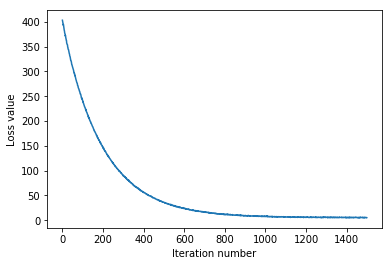

In [12]:
# 一个有用的debugging技巧是把损失函数画出来
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
# 完成LinearSVM.predict函数,并且在训练集和验证集上评估其准确性
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.380755
validation accuracy: 0.405000


In [14]:
# 使用验证集来调整超参数(正则化强度和学习率)。
# 你可以尝试不同的学习速率和正则化项的值;
# 如果你细心的话,您应该可以在验证集上获得大约0.39的准确率。

# 注意:在搜索超参数时，您可能会看到runtime/overflow的警告。
# 这是由极端超参值造成的,不是代码的bug。

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results是一个字典,把元组(learning_rate, regularization_strength)映射到元组(training_accuracy, validation_accuracy) 
# accuracy是样本中正确分类的比例
results = {}
best_val = -1   # 我们迄今为止见过最好的验证集准确率
best_svm = None # 拥有最高验证集准确率的LinearSVM对象

##############################################################################
# TODO：
# 编写代码，通过比较验证集的准确度来选择最佳超参数。
# 对于每个超参数组合，在训练集上训练一个线性SVM，在训练集和验证集上计算它的精度，
# 并将精度结果存储在results字典中。此外，在best_val中存储最高验证集准确度，
# 在best_svm中存储拥有此精度的SVM对象。
#
# 提示: 
# 在开发代码时，应该使用一个比较小的num_iter值，这样SVM就不会花费太多时间训练; 
# 一旦您确信您的代码开发完成，您就应该使用一个较大的num_iter值重新训练并验证。
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        # train svm 
        print("-------------------------------")
        print("lr: %.6f, reg: %5.1f"%(lr, reg))
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)

        # compute accuracy
        train_accuracy = np.mean(y_train == svm.predict(X_train))
        val_accuracy = np.mean(y_val == svm.predict(X_val))
        print('train accuracy: %.4f'%(train_accuracy))
        print('validation accuracy: %.4f'%(val_accuracy))

        # store accuracy in dictionary
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # check if validation accuracy is best
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
            
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# 打印results
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

-------------------------------
lr: 0.000000, reg: 25000.0
train accuracy: 0.3829
validation accuracy: 0.3880
-------------------------------
lr: 0.000000, reg: 50000.0
train accuracy: 0.3684
validation accuracy: 0.3930
-------------------------------
lr: 0.000050, reg: 25000.0
train accuracy: 0.1670
validation accuracy: 0.1750
-------------------------------
lr: 0.000050, reg: 50000.0


/data/2020_ecnu_dase_cv_assignment/assignment1/daseCV/classifiers/linear_svm.py:90: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/data/2020_ecnu_dase_cv_assignment/assignment1/daseCV/classifiers/linear_svm.py:90: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)


train accuracy: 0.0621
validation accuracy: 0.0550
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.382878 val accuracy: 0.388000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.368367 val accuracy: 0.393000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.166980 val accuracy: 0.175000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.062061 val accuracy: 0.055000
best validation accuracy achieved during cross-validation: 0.393000


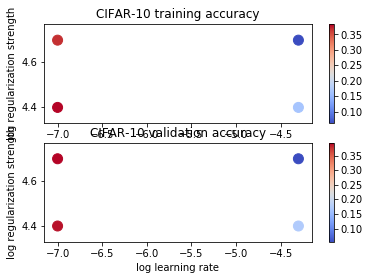

In [15]:
# 可是化交叉验证结果
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# 画出训练集准确率
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# 画出验证集准确率
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [16]:
# 在测试集上测试最好的SVM分类器
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.367000


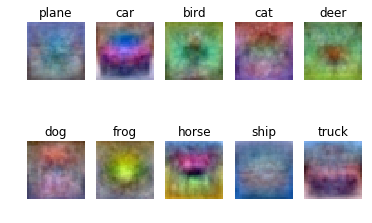

In [17]:
# 画出每一类的权重
# 基于您选择的学习速度和正则化强度，画出来的可能不好看
w = best_svm.W[:-1,:] # 去掉bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # 将权重调整为0到255之间
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**问题2**

描述你的可视化权值是什么样子的，并提供一个简短的解释为什么它们看起来是这样的。

$\color{blue}{ 你的回答： }$ 看起来像是每个类别图片的均值。
